In [15]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import torch
import pytorch_forecasting
import pytorch_lightning
import pytorch_lightning as pl

from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data import (TimeSeriesDataSet,TorchNormalizer,GroupNormalizer)

import pyarrow
import fastparquet
import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width : 98% !important; }</style>"))

pd.set_option('display.max_columns',500)

In [16]:
## Using the monthly alcohol volume sales dataset, link here: ('https://www.kaggle.com/datasets/bulentsiyah/for-simple-exercises-time-series-forecasting')
alcohol = pd.read_csv('/Users/APinkerton/Downloads/archive (18)/Alcohol_Sales.csv')
alcohol.columns = ['ds','y']

In [17]:
# Cleaning up the data & adding an elapsed time index to use as the time element for my neural network, and a static group id

alcohol['ds'] = pd.to_datetime(alcohol['ds'])
alcohol["elapsed_months"] = alcohol['ds'].dt.year * 12 + alcohol['ds'].dt.month
alcohol["elapsed_months"] -= alcohol["elapsed_months"].min()
alcohol["month"] = alcohol['ds'].dt.month.astype(str).astype("category")
alcohol['grp']='alcohol_vol'
alcohol

,ds,y,elapsed_months,month,grp
0,1992-01-01,3459,0,1,alcohol_vol
1,1992-02-01,3458,1,2,alcohol_vol
2,1992-03-01,4002,2,3,alcohol_vol
3,1992-04-01,4564,3,4,alcohol_vol
4,1992-05-01,4221,4,5,alcohol_vol
...,...,...,...,...,...
320,2018-09-01,12396,320,9,alcohol_vol
321,2018-10-01,13914,321,10,alcohol_vol
322,2018-11-01,14174,322,11,alcohol_vol
323,2018-12-01,15504,323,12,alcohol_vol


In [71]:
# Creating the time series dataset from the alcohol volume in pytorch. Also setting the validation length that I want to withhold from the training

max_prediction_length = 24
max_encoder_length = 96  ## Can play with this input to see how it affects the ending SMAPE -- 96 proved to be the best of the vlaues I tested
training_cutoff = alcohol["elapsed_months"].max() - max_prediction_length
norm = TorchNormalizer()
training = TimeSeriesDataSet(
    alcohol[lambda x: x['elapsed_months'] <= training_cutoff],
    time_idx="elapsed_months",
    target='y',
    group_ids=["grp"],
    min_encoder_length=0,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['grp'],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups=[],
    time_varying_known_reals=["elapsed_months"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['y'],
    target_normalizer=norm,
    add_relative_time_idx=True,  # adding time index as feature
    add_target_scales=True,  # adding scaled target variable as feature
    add_encoder_length=True,  # add length encoder as feature
)


In [72]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, alcohol, predict=True, stop_randomization=True)

## Creation of the training and test data loaders
batch_size = 128  # between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [73]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


3730.583251953125

In [74]:
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,  # Will test for the best LR in the next cell; this is just an initial setup 
    hidden_size=16,  # most important hyperparameter apart from learning rate
    attention_head_size=2,     # (up to 4 for large datasets)
    dropout=0.1,  # between 0.1 and 0.3
    hidden_continuous_size=8,  # <= hidden_size
    output_size=7,  # 7 = default
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4, ## When to reduce the LR if loss function doesn't drop after X number of epochs
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 18.7k


/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced

/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (3) is smaller than the l

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/APinkerton/.lr_find_eb38ebc2-c042-4329-b28d-56f25799659b.ckpt


suggested learning rate: 0.07943282347242808


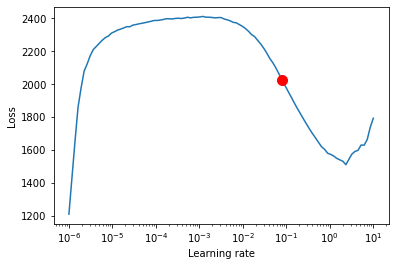

/var/folders/0g/4l0cmb9j43jgr0cxr8nx6sdm0000gn/T/ipykernel_22317/917049476.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [75]:
## Finding the ideal learning rate--using the built-in LR finding in pytorch
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [76]:
# configure network and trainer
my_lr = res.suggestion()
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=75,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,
    # fast_dev_run=True,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

## Creating the Temporal Fusion Transformer to train now that we have all the other functions set up

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=my_lr,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 = default
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 18.9k


In [77]:
# fitting
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [27]:
## Create what is essentially a GridSearchCV for the best hyperparameters for our model, save for later use
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - to use to predict later or to further tune
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# best hyperparameters:
print(study.best_trial.params)

/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
[I 2022-06-22 20:40:33,526] A new study created in memory with name: no-name-4b785410-1fd1-4148-b94e-3f9eedc2b92a
/Users/APinkerton/opt/an

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/Users/APinkerton/opt/ana

[I 2022-06-22 20:41:45,925] Trial 2 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:41:54,689] Trial 4 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we r

[I 2022-06-22 20:41:57,724] Trial 6 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we r

[I 2022-06-22 20:42:01,809] Trial 8 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we r

[I 2022-06-22 20:42:10,551] Trial 10 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:42:14,155] Trial 12 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:42:17,349] Trial 14 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:42:20,135] Trial 16 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:42:28,955] Trial 18 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:43:06,531] Trial 20 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:43:09,513] Trial 22 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:43:43,135] Trial 24 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:43:46,432] Trial 26 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:43:49,673] Trial 28 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:43:54,884] Trial 30 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:43:57,205] Trial 32 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:44:00,449] Trial 34 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:44:03,454] Trial 36 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:44:06,358] Trial 38 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:44:14,754] Trial 40 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:44:19,530] Trial 42 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:44:22,426] Trial 44 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:44:25,572] Trial 46 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:44:28,985] Trial 48 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:44:31,544] Trial 50 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:44:36,221] Trial 52 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:45:08,023] Trial 54 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:45:11,884] Trial 56 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:45:14,752] Trial 58 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:45:19,403] Trial 60 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:45:28,700] Trial 62 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:45:33,498] Trial 64 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:45:44,082] Trial 66 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:45:47,056] Trial 68 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Quant

[I 2022-06-22 20:47:42,111] Trial 70 finished with value: 729.1383666992188 and parameters: {'gradient_clip_val': 0.8141584433591211, 'hidden_size': 84, 'dropout': 0.17133417573663046, 'hidden_continuous_size': 43, 'attention_head_size': 3, 'learning_rate': 0.017785148734905838}. Best is trial 53 with value: 696.5365600585938.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` t

[I 2022-06-22 20:48:25,764] Trial 72 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 20:49:11,928] Trial 74 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:50:19,637] Trial 76 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:50:30,373] Trial 78 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:50:37,016] Trial 80 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:51:21,276] Trial 82 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:51:32,498] Trial 84 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:51:40,026] Trial 86 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:51:49,442] Trial 88 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:52:14,228] Trial 90 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:54:51,936] Trial 92 finished with value: 766.5900268554688 and parameters: {'gradient_clip_val': 0.9160181004528711, 'hidden_size': 83, 'dropout': 0.20595673155128327, 'hidden_continuous_size': 45, 'attention_head_size': 3, 'learning_rate': 0.0273880070714809}. Best is trial 53 with value: 696.5365600585938.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` tha

[I 2022-06-22 20:55:35,550] Trial 94 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 20:56:12,108] Trial 96 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:56:21,855] Trial 98 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we 

[I 2022-06-22 20:56:40,423] Trial 100 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 20:59:10,818] Trial 102 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and w

[I 2022-06-22 21:01:52,066] Trial 104 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:02:17,735] Trial 106 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:03:13,531] Trial 108 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilit

[I 2022-06-22 21:03:16,416] Trial 110 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilit

/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this

[I 2022-06-22 21:04:26,053] Trial 113 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and w

[I 2022-06-22 21:07:52,828] Trial 115 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and w

[I 2022-06-22 21:08:55,293] Trial 117 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:09:30,565] Trial 119 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilit

[I 2022-06-22 21:09:49,778] Trial 121 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:10:50,774] Trial 123 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (Qua

[I 2022-06-22 21:10:54,928] Trial 125 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:11:07,307] Trial 127 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilit

[I 2022-06-22 21:11:23,123] Trial 129 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:12:08,827] Trial 131 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and w

[I 2022-06-22 21:13:01,744] Trial 133 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utili

[I 2022-06-22 21:13:04,914] Trial 135 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:13:28,770] Trial 137 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:15:38,762] Trial 139 finished with value: 729.52880859375 and parameters: {'gradient_clip_val': 0.74622677255883, 'hidden_size': 85, 'dropout': 0.23411063441429347, 'hidden_continuous_size': 47, 'attention_head_size': 3, 'learning_rate': 0.09833359084093204}. Best is trial 53 with value: 696.5365600585938.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Use

[I 2022-06-22 21:16:24,222] Trial 141 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and w

[I 2022-06-22 21:20:22,867] Trial 143 finished with value: 720.2337036132812 and parameters: {'gradient_clip_val': 0.9260643420519437, 'hidden_size': 128, 'dropout': 0.20519682401221168, 'hidden_continuous_size': 37, 'attention_head_size': 3, 'learning_rate': 0.09979892490314256}. Best is trial 53 with value: 696.5365600585938.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept

[I 2022-06-22 21:21:22,070] Trial 145 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and w

[I 2022-06-22 21:21:57,881] Trial 147 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:22:25,138] Trial 149 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilit

[I 2022-06-22 21:22:37,595] Trial 151 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:22:54,807] Trial 153 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilit

[I 2022-06-22 21:23:14,461] Trial 155 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:23:22,466] Trial 157 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:24:15,790] Trial 159 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilit

[I 2022-06-22 21:24:18,452] Trial 161 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:24:34,910] Trial 163 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:24:44,846] Trial 165 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:28:12,700] Trial 167 finished with value: 709.23193359375 and parameters: {'gradient_clip_val': 0.9600919929590711, 'hidden_size': 108, 'dropout': 0.21400620616611749, 'hidden_continuous_size': 40, 'attention_head_size': 3, 'learning_rate': 0.060036890667448224}. Best is trial 53 with value: 696.5365600585938.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` t

[I 2022-06-22 21:31:16,246] Trial 169 finished with value: 705.6904907226562 and parameters: {'gradient_clip_val': 0.9341280186321425, 'hidden_size': 118, 'dropout': 0.20905174549065783, 'hidden_continuous_size': 41, 'attention_head_size': 2, 'learning_rate': 0.0456075348206638}. Best is trial 53 with value: 696.5365600585938.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` t

[I 2022-06-22 21:32:22,013] Trial 171 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and w

[I 2022-06-22 21:32:35,221] Trial 173 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:33:29,748] Trial 175 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:36:48,069] Trial 177 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:37:24,448] Trial 179 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:38:24,457] Trial 181 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and w

[I 2022-06-22 21:40:21,776] Trial 183 pruned. Trial was pruned at epoch 16.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and w

[I 2022-06-22 21:40:43,708] Trial 185 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:41:15,880] Trial 187 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilit

[I 2022-06-22 21:41:18,941] Trial 189 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/integration/pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this

[I 2022-06-22 21:41:51,152] Trial 192 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:42:12,490] Trial 194 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilit

[I 2022-06-22 21:42:15,369] Trial 196 pruned. Trial was pruned at epoch 1.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

[I 2022-06-22 21:42:41,410] Trial 198 pruned. Trial was pruned at epoch 4.
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we

{'gradient_clip_val': 0.46945809915019, 'hidden_size': 14, 'dropout': 0.2217124058478718, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.08049578081283154}


In [81]:
## Loading the model with the best val_loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/APinkerton/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [82]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1304.5006)

In [83]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

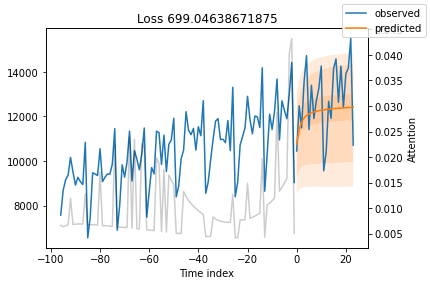

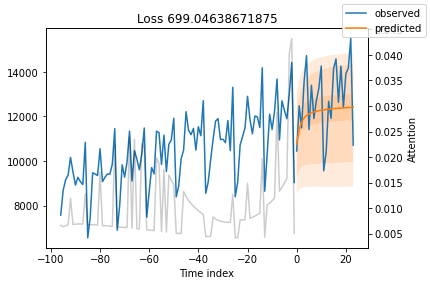

In [85]:
## Plotting predictions versus our actuals
best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)